# Import

In [60]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

import os
import shutil


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import scipy
from scipy.signal import find_peaks

import inspect
from tqdm import tqdm


In [107]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


def generate_data(dossier, seq_len=1900, nb_channel=5):

    data = []
    
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)
            list_data_from_file = [data_f3]

            data.append(list_data_from_file)

    nb_files = len(data)
    return np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

In [108]:
folder_path = "echantillon"
# folder_path = r"/home/user/Documents/Data/matrix" # Chemin vers le dossier avec toutes la data

seq_len = 1900
nb_channels = 1

In [109]:
data_echantillon = generate_data(folder_path, seq_len=seq_len, nb_channel=nb_channels)

In [110]:
def affichage_data(signal, seq_len=1900, nb_channels=5, info_text="Signal"):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(20, 6), sharex=True)

    if nb_channels == 1 :
        axs = [axs]

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[i].reshape(seq_len), label=f'Signal {i+1}')
        axs[i].grid()
    
    plt.suptitle(info_text)
    plt.show()

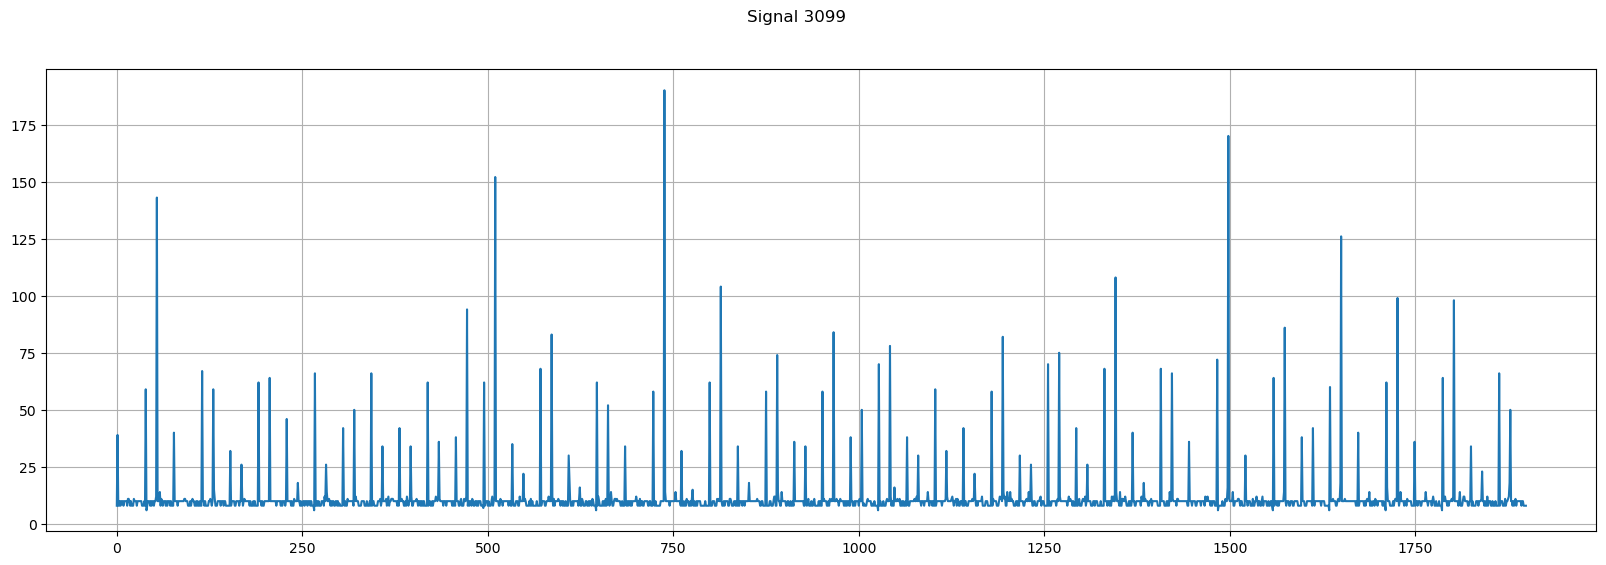

In [111]:
indice_signal = np.random.randint(0, data_echantillon.shape[0])

affichage_data(data_echantillon[indice_signal], seq_len=seq_len, nb_channels=nb_channels, info_text=f"Signal {indice_signal}")

In [112]:
data_echantillon.shape

(5000, 1, 1, 1900)

In [121]:
import numpy as np
from scipy.fft import fft
from scipy.stats import kurtosis, skew
import pywt  # Pour les ondelettes

def extract_features(time_series):
    features = []

    # Max et Min
    features.append(np.max(time_series))
    features.append(np.min(time_series))
    
    # Moyenne et variance
    features.append(np.mean(time_series))
    features.append(np.var(time_series))
    
    # Skewness et Kurtosis
    features.append(skew(time_series))
    features.append(kurtosis(time_series))
    
    # Transformation de Fourier - fréquence dominante
    fft_result = fft(time_series)
    freqs = np.fft.fftfreq(len(time_series))
    dominant_freq = np.abs(fft_result).argmax()
    features.append(dominant_freq)
    
    # Décomposition en ondelettes (par exemple, Haar)
    coeffs = pywt.wavedec(time_series, 'haar', level=5)
    wavelet_energy = np.sum(np.square(coeffs[0]))  # énergie de la composante de bas niveau
    features.append(wavelet_energy)
    
    return features

In [122]:
# Exemple pour 5000 séries temporelles de longueur 1900
X_features = np.array([extract_features(ts[0, 0, :]) for ts in data_echantillon])

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)


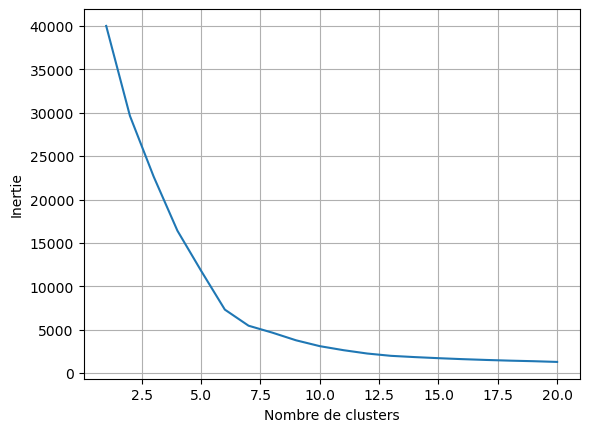

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [128]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Trouver un bon nombre de clusters avec la méthode du coude
inertia = []
max_cluster=20
for k in range(1, max_cluster+1):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X_features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_cluster+1), inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/user/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/user/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/user/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Cat

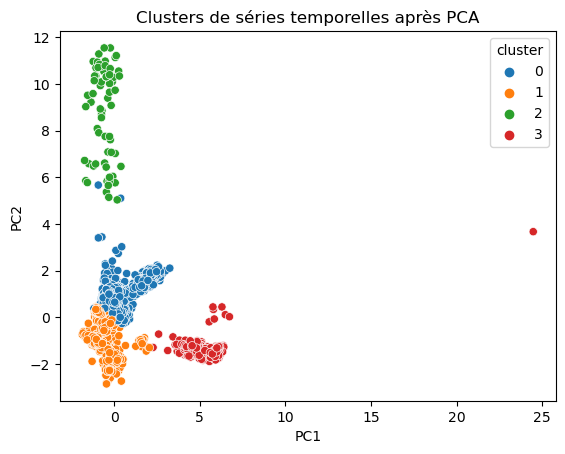

In [134]:
import seaborn as sns
import pandas as pd

nb_clusters = 4

# Appliquer K-means avec k optimal (par exemple, k=3)
kmeans = KMeans(n_clusters=nb_clusters, random_state=0)
kmeans.fit(X_features_scaled)

# Les labels de cluster pour chaque série
labels = kmeans.labels_

# Ajouter les labels au dataframe
df = pd.DataFrame(X_features_scaled)
df['cluster'] = kmeans.labels_

# Visualisation des premiers composants avec PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df.drop(columns=['cluster']))
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title('Clusters de séries temporelles après PCA')
plt.show()


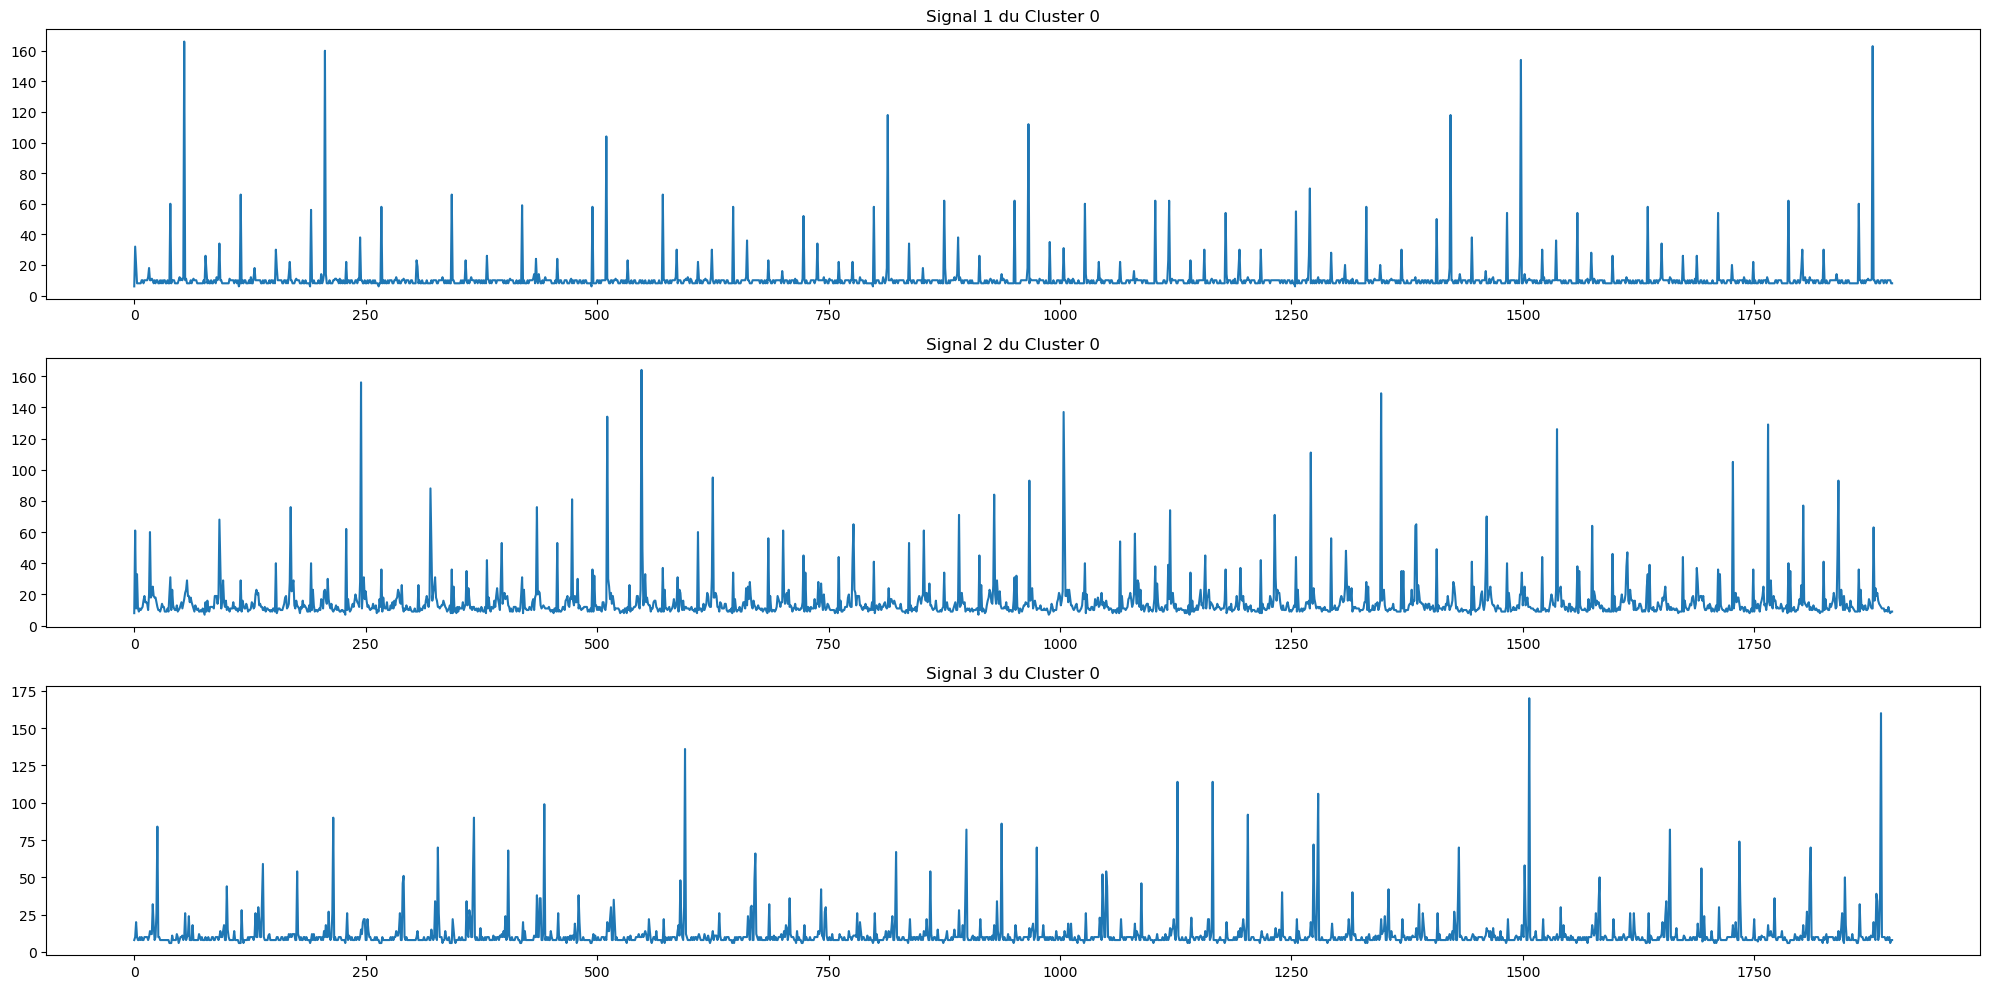

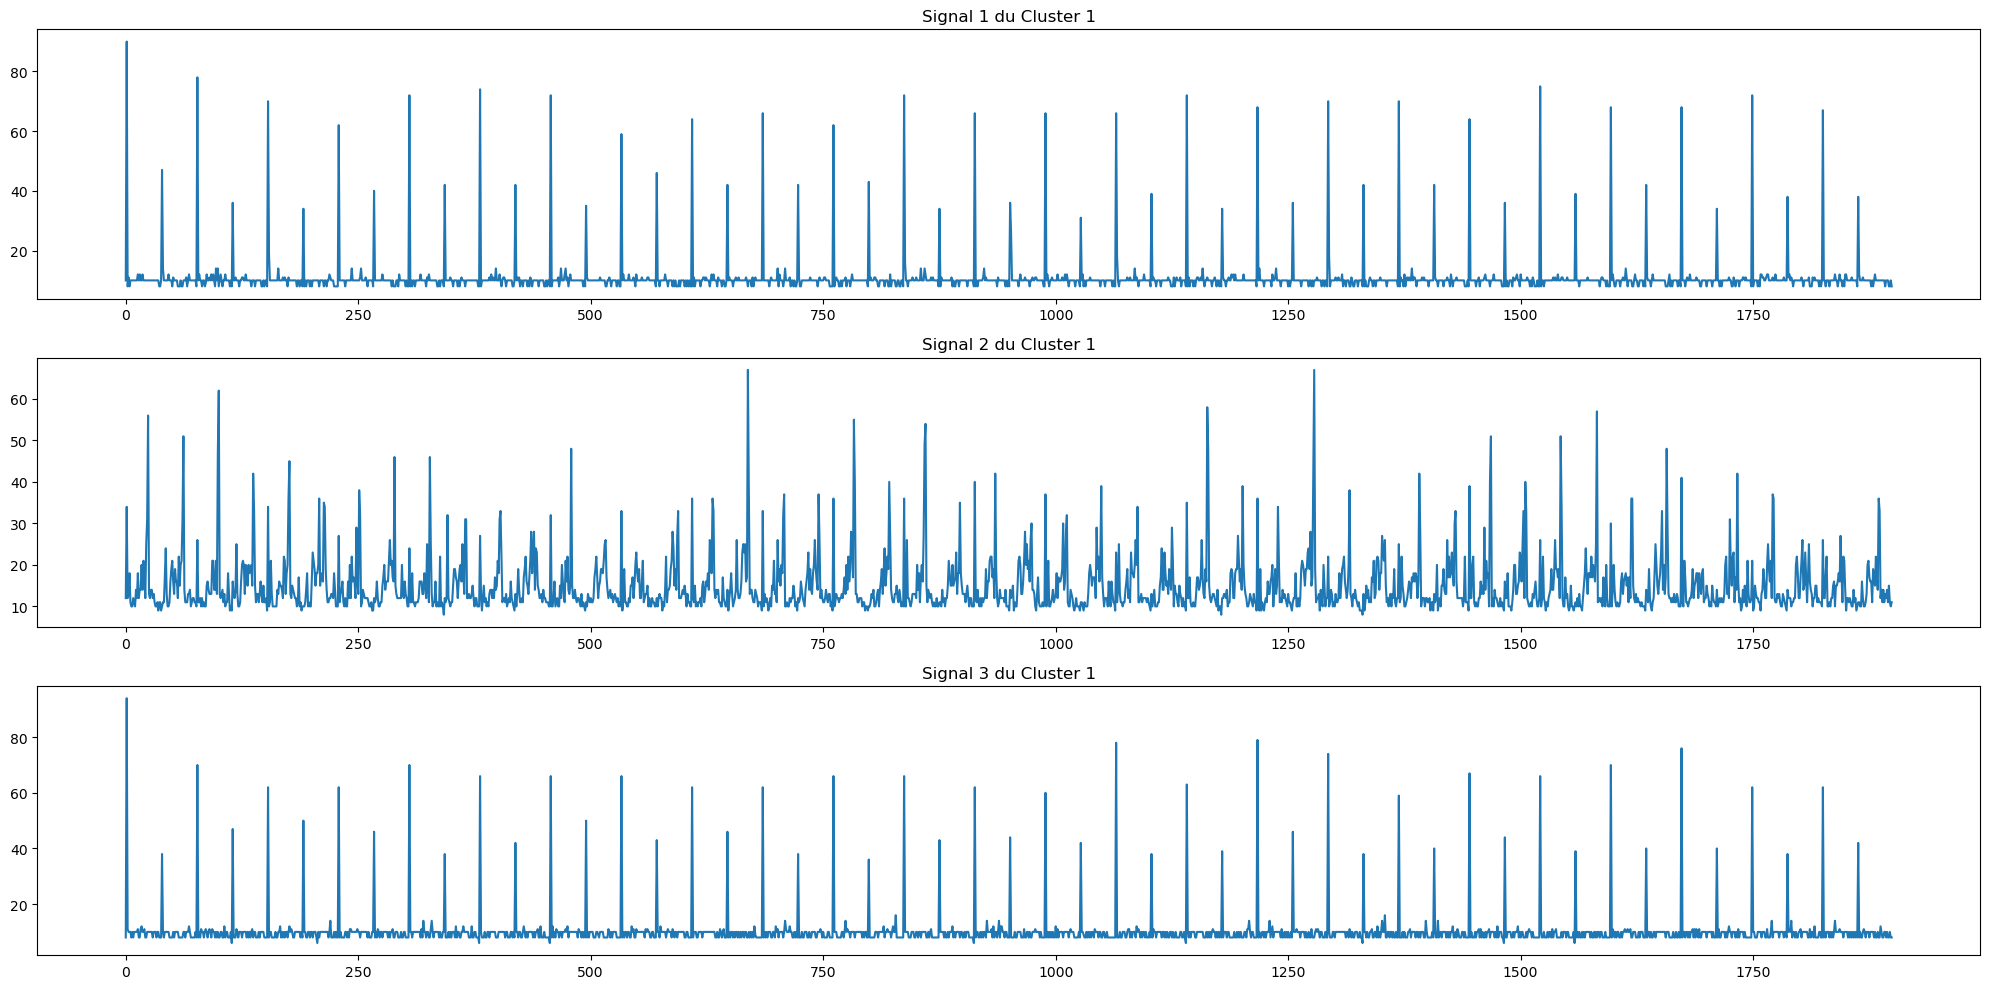

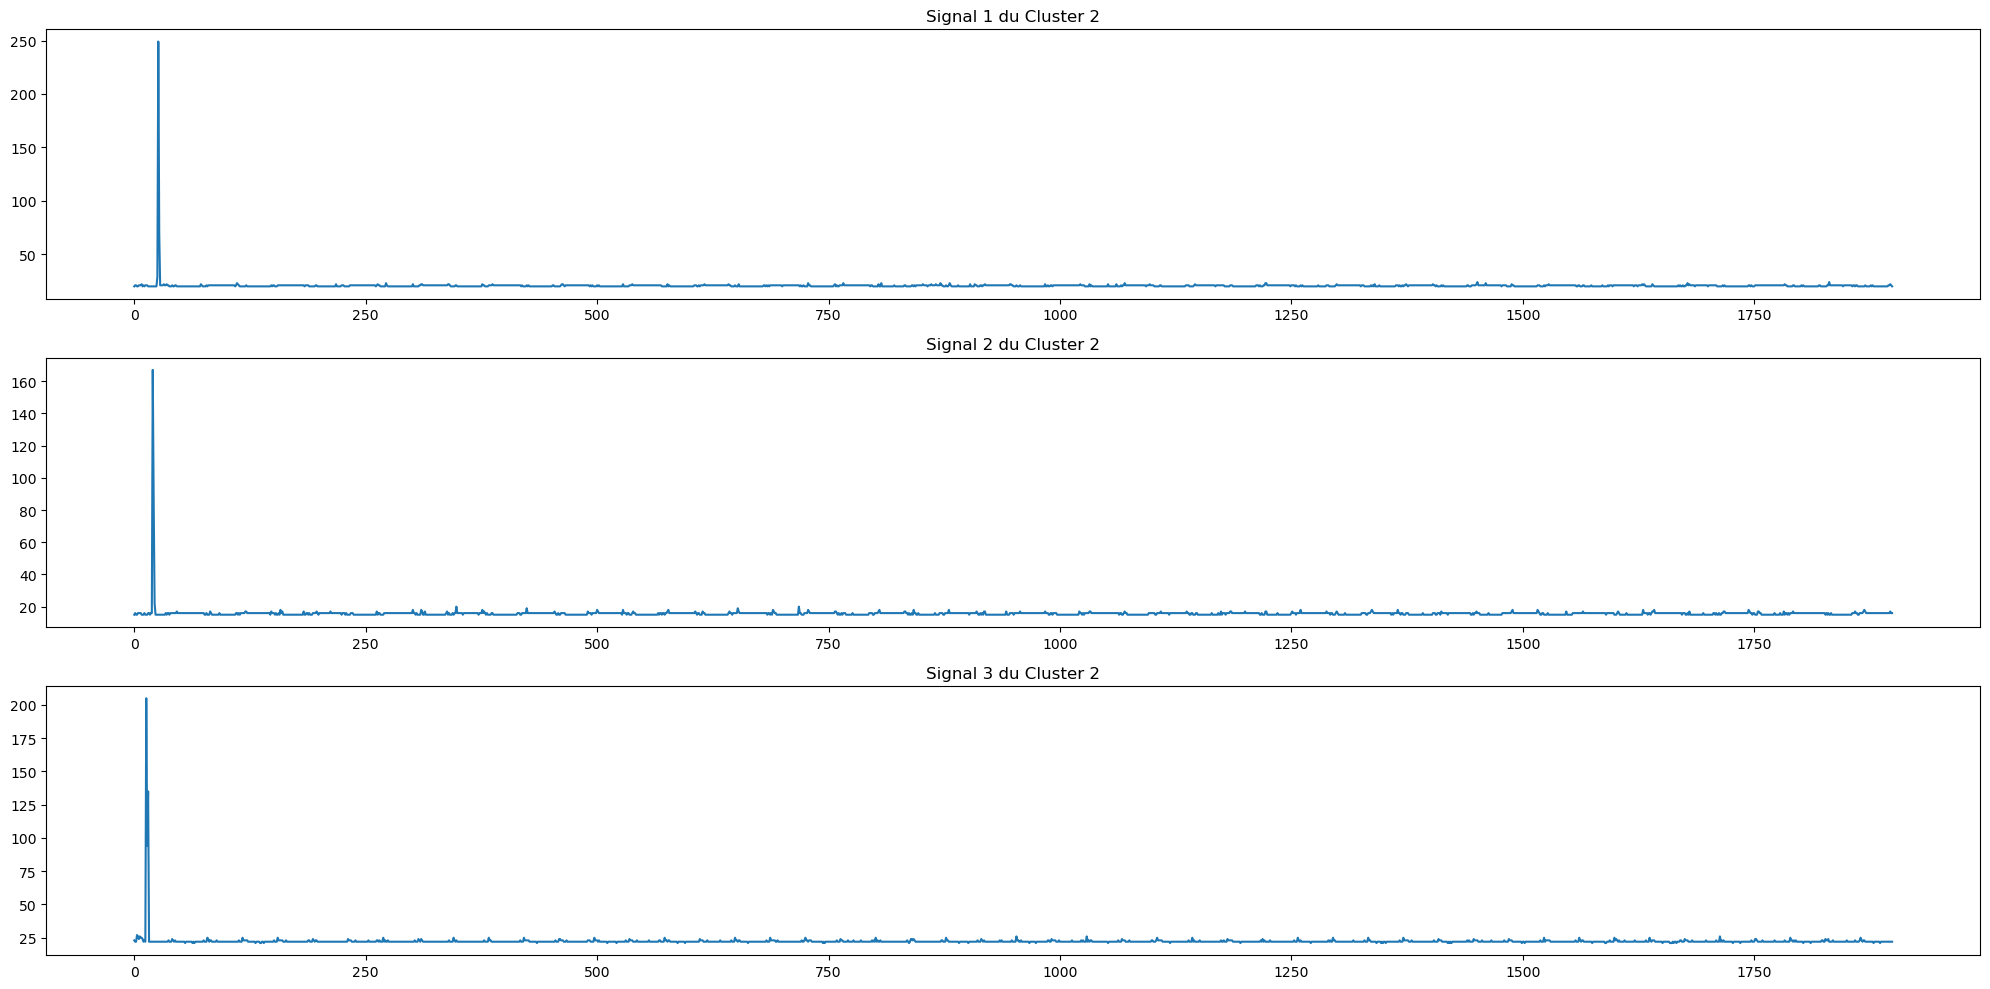

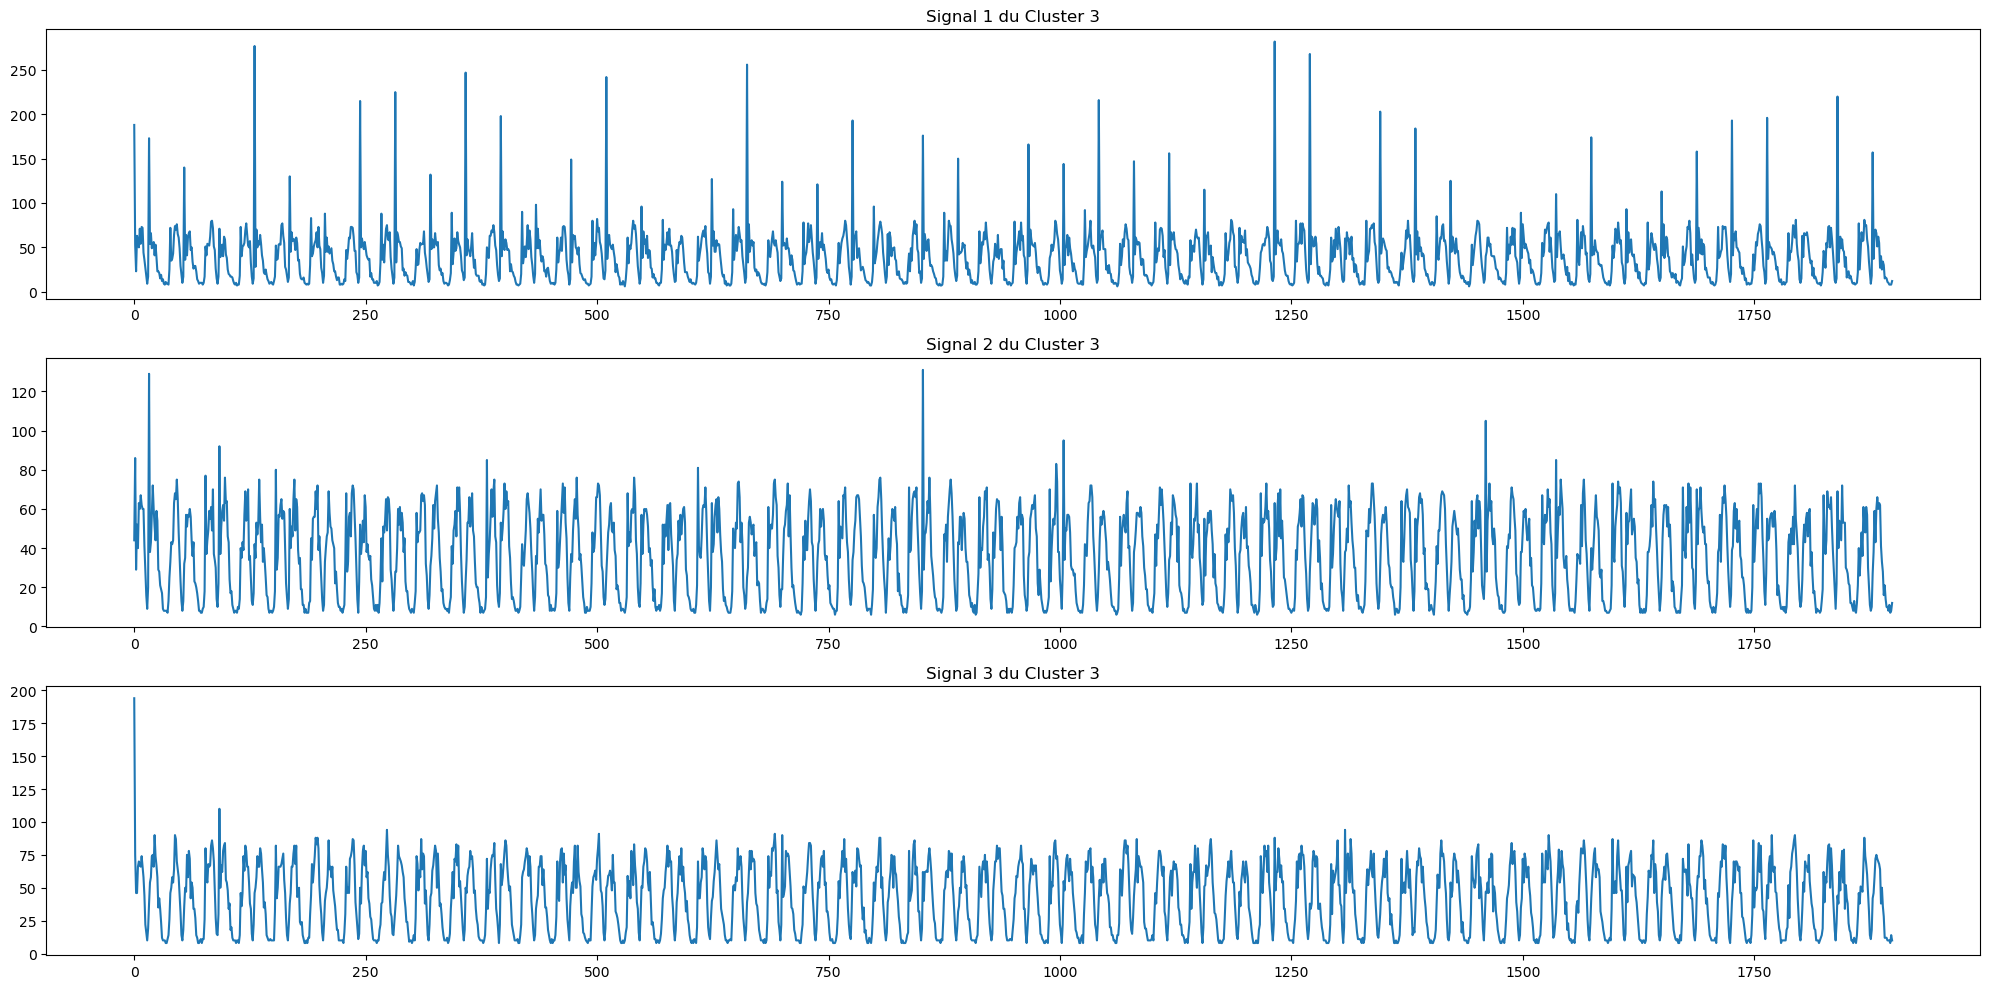

In [135]:
def affiche_data(X, labels, cluster_num, num_signals=1):
    """
    Affiche `num_signals` séries temporelles du cluster spécifié par `cluster_num`.
    
    X : array-like, shape (n_samples, n_features)
        Les données contenant toutes les séries temporelles.
    labels : array-like, shape (n_samples,)
        Les labels de cluster pour chaque série temporelle.
    cluster_num : int
        Le numéro du cluster à afficher.
    num_signals : int
        Le nombre de signaux à afficher.
    """
    # Trouver les indices des séries temporelles appartenant au cluster cluster_num
    cluster_indices = np.where(labels == cluster_num)[0]
    
    # Sélectionner un sous-ensemble des indices pour afficher les signaux
    selected_indices = np.random.choice(cluster_indices, num_signals)
    
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_signals, 1, i + 1)
        plt.plot(X[idx, 0, 0])
        plt.title(f'Signal {i+1} du Cluster {cluster_num}')
        plt.tight_layout()
    plt.show()

# Exemple d'affichage pour les 3 premiers clusters
n_clusters = np.max(kmeans.labels_) + 1  # Nombre de clusters dans k-means

for cluster_num in range(n_clusters):
    affiche_data(data_echantillon, kmeans.labels_, cluster_num, num_signals=3)